# Credit Information Learning

## 1) Goal
This assignment requires learners to:
- Build a **baseline** classifier and submit predictions in the correct Kaggle format
- Use **scikit-learn Pipelines** for clean preprocessing + modeling
- Evaluate with the **competition metric** (ROC-AUC) and common metrics (accuracy, precision, recall, F1)
- Add **feature engineering**, run **multiple experiments** (≥5), compare via cross-validation
- Generate a final **submission CSV** for Kaggle (`SK_ID_CURR`, `TARGET`)

## 2) Competition context
- **Task**: Predict whether an applicant will **default** in the future (`TARGET`: 1 = default, 0 = non-default).
- **Train file**: `application_train.csv` (has `TARGET`), **Test file**: `application_test.csv` (no `TARGET`).
- **Submission**: CSV with columns **`SK_ID_CURR`** and **`TARGET`** (the predicted **probability** of default).
- **Primary metric**: **ROC–AUC** (Area Under the Receiver Operating Characteristic Curve).

## 3) Load data
Ensure that `application_train.csv` and `application_test.csv` are saved in the same file as this notebook

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

train_path = Path("application_train.csv")
test_path  = Path("application_test.csv")

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path) if test_path.exists() else None

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)
train_df.head()

Train shape: (307511, 122)
Test  shape: (48744, 121)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
test_df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## 4) Quick EDA
Check target distribution and a brief look at missingness.

In [3]:
# TARGET distribution
target_counts = train_df["TARGET"].value_counts(normalize=True) * 100
print("TARGET distribution (%):\n", target_counts.sort_index())

# Top missing ratios (train)
missing_ratio = train_df.isna().sum().sort_values(ascending=False) / len(train_df)
print("\nTop missing (train):")
print(missing_ratio.head(15))

TARGET distribution (%):
 TARGET
0    91.927118
1     8.072882
Name: proportion, dtype: float64

Top missing (train):
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
COMMONAREA_MEDI             0.698723
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_AVG        0.683550
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
FLOORSMIN_MODE              0.678486
FLOORSMIN_AVG               0.678486
FLOORSMIN_MEDI              0.678486
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MODE            0.664978
dtype: float64


## 5) Baseline model - Logistic Regression
Simple but robust:
- Basic **feature engineering** (ratios & ages)
- Split train/validation once
- **Pipeline**: impute → scale → logistic regression
- Evaluate with **ROC–AUC**, **accuracy**, **precision**, **recall**, **F1**
- Visualize **ROC** and **Precision–Recall** curves + **confusion matrix**

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, f1_score
)

In [18]:
# Feature Engineering
def add_features(df):
    out = df.copy()
    out["DAYS_EMPLOYED"] = out["DAYS_EMPLOYED"].replace(365243, np.nan) # Highlighted by kaggle users. Equivalent of 1000 years!!
    out["AGE_YEARS"] = (-out["DAYS_BIRTH"]/365).astype(float) # To years
    out["EMPLOYED_YEARS"] = (-out["DAYS_EMPLOYED"]/365).astype(float)
    if {"AMT_CREDIT","AMT_INCOME_TOTAL"}.issubset(out.columns):
        out["CREDIT_INCOME_RATIO"] = out["AMT_CREDIT"]/out["AMT_INCOME_TOTAL"].replace(0,np.nan)
    if {"AMT_ANNUITY","AMT_INCOME_TOTAL"}.issubset(out.columns):
        out["ANNUITY_INCOME_RATIO"] = out["AMT_ANNUITY"]/out["AMT_INCOME_TOTAL"].replace(0,np.nan)
    return out

train = add_features(train_df)
test  = add_features(test_df)

features = [
    "EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3",
    "AMT_CREDIT","AMT_INCOME_TOTAL","AMT_ANNUITY",
    "AGE_YEARS","EMPLOYED_YEARS","CREDIT_INCOME_RATIO","ANNUITY_INCOME_RATIO"
]
features = [f for f in features if f in train.columns]

X = train[features]
y = train["TARGET"].astype(int)
X_test_final = test[features]

print("Selected features:", features)

Selected features: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'AMT_CREDIT', 'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'AGE_YEARS', 'EMPLOYED_YEARS', 'CREDIT_INCOME_RATIO', 'ANNUITY_INCOME_RATIO']


In [20]:
models = {
    "Logistic Regression": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced")) # parameters
    ]),
    "Random Forest": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", RandomForestClassifier(n_estimators=200, random_state=42,
                                       n_jobs=-1, class_weight="balanced_subsample")) # parameter tuning
    ]),
    "HistGradientBoosting": Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("clf", HistGradientBoostingClassifier(random_state=42))
    ])
}

print("Models ready:", list(models.keys()))

Models ready: ['Logistic Regression', 'Random Forest', 'HistGradientBoosting']


## 6) Experiments - multiple pipelines & feature sets
Run several models via pipeline and compare **ROC–AUC** via 3-fold **Stratified CV**.

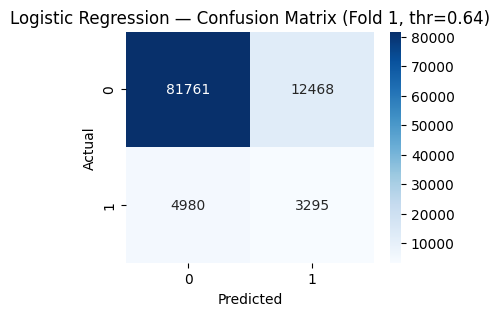

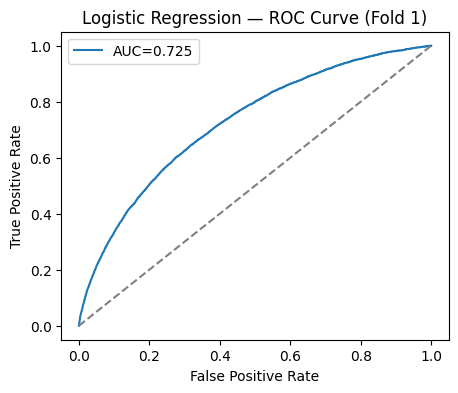

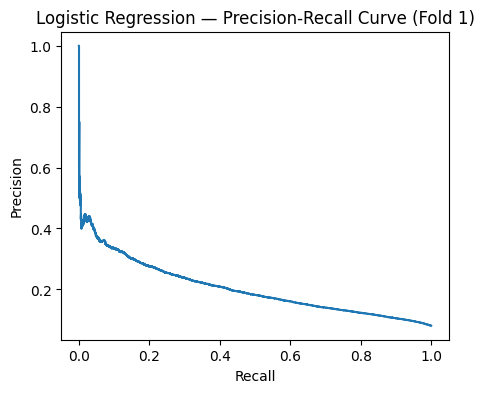

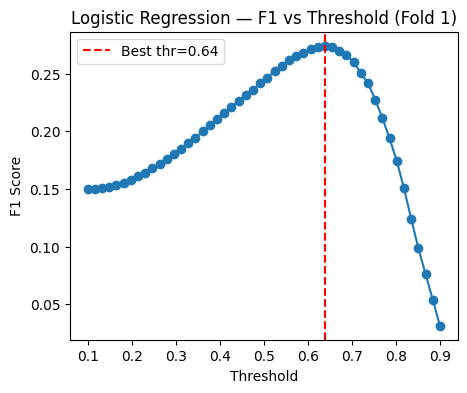

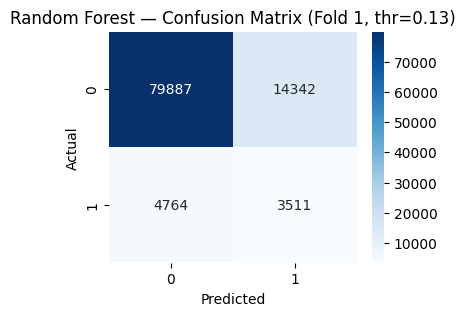

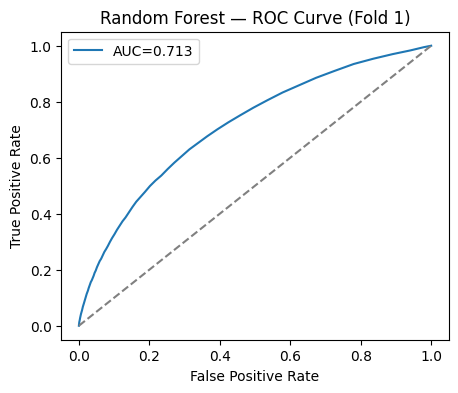

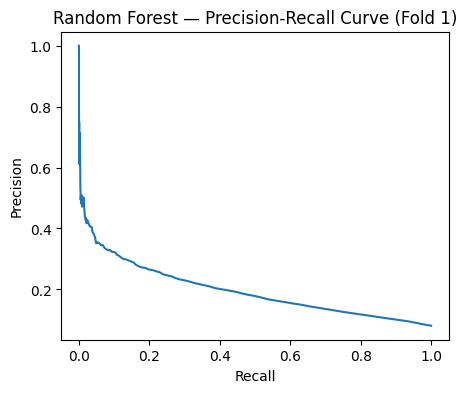

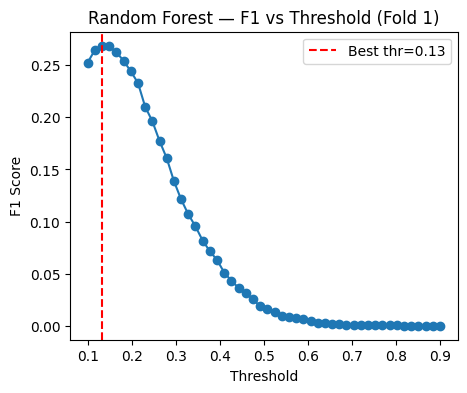

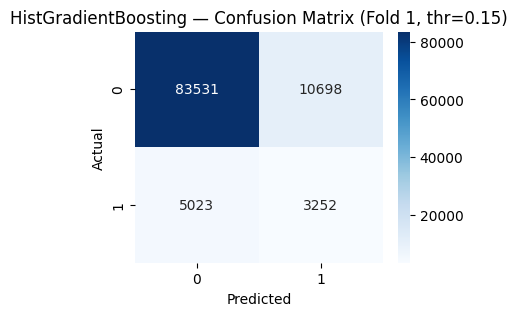

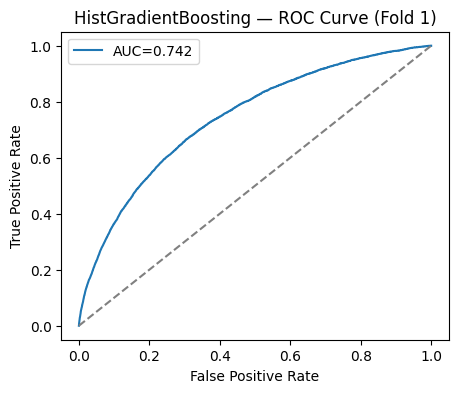

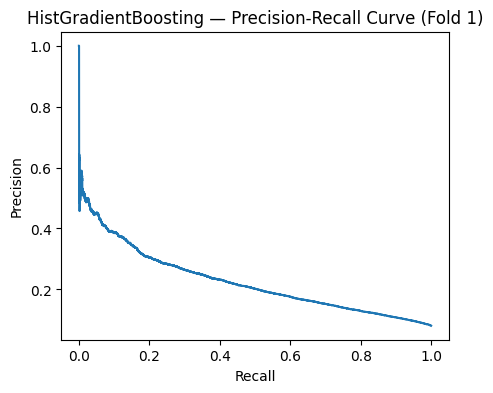

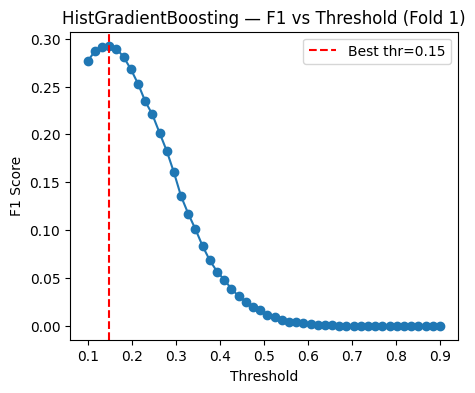

,Model,ROC-AUC Mean,ROC-AUC Std,F1 Mean,F1 Std
2,HistGradientBoosting,0.739426,0.002220,0.289260,0.002394
0,Logistic Regression,0.723333,0.002790,0.271199,0.004196
1,Random Forest,0.711861,0.000692,0.267420,0.001105


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = []

for name, pipe in models.items():
    aucs, f1s = [], []

    for fold, (train_idx, val_idx) in enumerate(cv.split(X, y), 1):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        pipe.fit(X_tr, y_tr)
        y_proba = pipe.predict_proba(X_val)[:,1]

        # ROC-AUC
        auc = roc_auc_score(y_val, y_proba)
        aucs.append(auc)

        # Threshold optimization for F1
        thresholds = np.linspace(0.1,0.9,50)
        f1_scores = [f1_score(y_val, (y_proba >= t).astype(int), zero_division=0) for t in thresholds]
        best_f1 = max(f1_scores)
        best_t = thresholds[np.argmax(f1_scores)]
        f1s.append(best_f1)

        if fold == 1:  # Only plot once (to save time)
            # Confusion Matrix
            y_pred = (y_proba >= best_t).astype(int)
            cm = confusion_matrix(y_val, y_pred)
            plt.figure(figsize=(4,3))
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
            plt.title(f"{name} - Confusion Matrix (Fold 1, thr={best_t:.2f})")
            plt.xlabel("Predicted"); plt.ylabel("Actual")
            plt.show()

            # ROC Curve
            fpr, tpr, _ = roc_curve(y_val, y_proba)
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, label=f"AUC={auc:.3f}")
            plt.plot([0,1],[0,1],"--", color="gray")
            plt.title(f"{name} - ROC Curve (Fold 1)")
            plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
            plt.legend(); plt.show()

            # Precision–Recall Curve
            prec, rec, _ = precision_recall_curve(y_val, y_proba)
            plt.figure(figsize=(5,4))
            plt.plot(rec, prec)
            plt.title(f"{name} - Precision-Recall Curve (Fold 1)")
            plt.xlabel("Recall"); plt.ylabel("Precision")
            plt.show()

            # F1 vs Threshold Curve
            plt.figure(figsize=(5,4))
            plt.plot(thresholds, f1_scores, marker="o")
            plt.axvline(best_t, color="red", linestyle="--", label=f"Best thr={best_t:.2f}")
            plt.title(f"{name} - F1 vs Threshold (Fold 1)")
            plt.xlabel("Threshold"); plt.ylabel("F1 Score")
            plt.legend(); plt.show()

    results.append({
        "Model": name,
        "ROC-AUC Mean": np.mean(aucs),
        "ROC-AUC Std": np.std(aucs),
        "F1 Mean": np.mean(f1s),
        "F1 Std": np.std(f1s)
    })

results_df = pd.DataFrame(results).sort_values("ROC-AUC Mean", ascending=False)
results_df


## 7) Fit best pipeline on full training & create submission


In [22]:
best_model_name = results_df.iloc[0]["Model"]
print("Best model:", best_model_name)

best_pipe = models[best_model_name]
best_pipe.fit(X, y)
test_pred = best_pipe.predict_proba(X_test_final)[:,1]

submission = pd.DataFrame({
    "SK_ID_CURR": test["SK_ID_CURR"],
    "TARGET": test_pred
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv with", best_model_name)

Best model: HistGradientBoosting
Saved submission.csv with HistGradientBoosting
